# We need to explore more possible datasets that we could possibly use

In [1]:
from welly import Project, Well
import glob
from tqdm.notebook import tqdm
import pandas as pd
from contextlib import suppress
from multiprocessing.pool import Pool
import matplotlib.pyplot as plt
import pickle
import os

In [2]:
def create_project(year):
    wells = []
    for name in tqdm(glob.glob(f"logs/{year}/*.las")):
        try:
            wells.append(Well.from_las(name, index="f"))
        except:
            pass
    p = Project(wells)
    return p, wells

## Choose the year 

In [3]:
year = 2016

In [4]:
p, wells = create_project(year)

  0%|          | 0/2283 [00:00<?, ?it/s]

/home/fastfist/.local/share/virtualenvs/transformers-kgQS_UHh/lib/python3.8/site-packages/welly/curve.py:216: UserWarning: Irregular sampling in depth is not supported. Interpolating to regular basis.
  warnings.warn(m)
/home/fastfist/.local/share/virtualenvs/transformers-kgQS_UHh/lib/python3.8/site-packages/lasio/las.py:284: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  arr[arr == provisional_null] = np.nan


In [5]:
curves = pd.read_csv(f"meta_tags/{year}/all_attr_curves.csv")
well   = pd.read_csv(f"meta_tags/{year}/all_attr_well.csv")

# Look at some metavalues and curves

In [6]:
curves.sort_values(by=["Frequency", "Name"], ascending=False).head(10)

,Name,Frequency
0,DEPT,2077
6,GR,1961
14,SP,1756
5,DPOR,1548
12,RLL3,1495
10,RILD,1491
11,RILM,1490
9,RHOC,1490
4,DCAL,1490
8,RHOB,1460


In [7]:
well.sort_values(by=["Frequency", "Name"], ascending=False).head(10)

,Name,Frequency
5,WELL,2278
0,STRT,2278
1,STOP,2278
2,STEP,2278
7,LOC,2278
6,FLD,2278
4,COMP,2278
3,NaN,2278
12,STAT,2271
10,DATE,2267


# Lets work on Extracting Curves first

The curves provider far more information when compared to the Well data, especially since the meta extration does not account for empty frames attributes that were included by default

In [8]:
keys = {
    "Gamma",       # Gamma Ray
    "Resist",      # Deep / Medium Resistivity
    "Shallow",     # Shallow Resistivity
    "SP",          # Sponatenous Potential
    "Caliper",     # CDL Caliper (Hole has not washed out/blown ou t)
    "Density Corr",# Density Correction
    "Density Por"  # Density Porosity
}

alias = {
    "Gamma": ["GRGC", "GR", "GRGC", "GAMMARAY", "GRE", "GRGM", "GK1", "GRX", "G/R", "GAMMA", "GR_EDTC", "GAMMA:2", "GR:1", "GRGC:1"],
    "Resist": ["RILD", "RILM"],
    "Shallow": ["RLL3"],
    "Caliper": ["DCAL"],
    "Density Corr": ["RHOC"],
    "Density Por": ["DPOR"]
}
filtered_project = p.filter_wells_by_data(keys, alias=alias, func='all')
# Lets see how much data we lose from this reduction
f"{len(p.filter_wells_by_data(keys, alias=alias, func='nall')) *100/ len(p)} % Reduction"

'37.110232762406675 % Reduction'

In [9]:
from collections import Counter
"""
Quick method to create a counter object out of the well curves
"""
def find_well_similarities(project) -> Counter:
    attr = []
    for well in project:
        attr.extend(well.get_mnemonics_from_regex(".*")) # This gives us all the wells (Couldn't find a better way)
    return Counter(attr)    

What other things can we ad into this dataset without a large loss?

In [10]:
find_well_similarities(filtered_project).most_common()

[('DCAL', 1432),
 ('DPOR', 1432),
 ('RHOC', 1432),
 ('RILD', 1432),
 ('RLL3', 1432),
 ('SP', 1432),
 ('RILM', 1431),
 ('GR', 1430),
 ('RHOB', 1218),
 ('RXORT', 1210),
 ('AVTX', 1004),
 ('BVTX', 1004),
 ('MI', 987),
 ('MN', 987),
 ('MCAL', 975),
 ('CILD', 946),
 ('CNLS', 936),
 ('DGA', 673),
 ('DT', 565),
 ('SPOR', 565),
 ('ITT', 562),
 ('CNPOR', 370),
 ('MEL15', 243),
 ('MEL20', 243),
 ('MELCAL', 242),
 ('NPOR', 211),
 ('CNSS', 197),
 ('CNDL', 196),
 ('ABHV', 189),
 ('TBHV', 188),
 ('LSPD', 87),
 ('LTEN', 87),
 ('PE', 86),
 ('SSD', 58),
 ('MINMK', 9),
 ('RWA', 6),
 ('LSD', 5),
 ('XPLITHO', 3),
 ('RXO\\RT', 3),
 ('PEF', 2),
 ('ADPTH', 2),
 ('NEU', 2),
 ('UNKNOWN', 1),
 ('DEVI', 1),
 ('TT1', 1),
 ('GR:1', 1),
 ('GR:2', 1),
 ('HVOLTA', 1),
 ('CILM', 1),
 ('CLL3', 1),
 ('LSDEN', 1),
 ('SSDEN', 1),
 ('LSPOR', 1),
 ('SSPOR', 1),
 ('HEADVOLT', 1),
 ('GRGC', 1)]

# Check Diversity

I am possibly worried that due to the reductions made, the now filtered wells could be biased based upon company/location drilled in. Lets make density maps of this once again to ensure this has not happened

In [11]:
corrections = {
    "ELI WIRELINE": "NA",
    "LGAN": "LOGAN",
    "SALINA": "SALINE",
    "HARPER CO": "HARPER",
    "HARPER CO.": "HARPER",
    "SUMMER": "SUMNER",
    "SEDOWICK": "SEDGWICK",
    "ELLS": "ELLIS",
    "NESS CO.": "NESS",
    '': "NA",
    "HODGMAN": "HODGEMAN",
    "USA" : "NA",
    "KANSAS" : "NA",
    "RUSSEL" : "RUSSELL",
    "PRATT COUNTY" : "PRATT",
    "WITCHITA" : "WICHITA",
    "RUCH" : "RUSH",
    "RAWLINGS" : "RAWLINS",
    "KEARNEY": "KEARNY",
    "STATON": "STANTON"
}

all_locations = [ getattr(well.location, 'county', "NA").upper() for well in filtered_project]
all_locations = [ corrections.get(loc, loc) for loc in all_locations]
location_count = Counter(all_locations)


raw_locations = [ getattr(well.location, 'county', "NA").upper() for well in p]
raw_locations = [ corrections.get(loc, loc) for loc in raw_locations]
raw_location_count = Counter(raw_locations)

<AxesSubplot:>

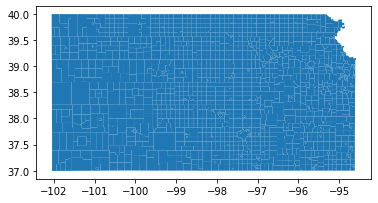

In [12]:
import geopandas as gpd
kansas_map = gpd.read_file("kansas.zip")
kansas_map.plot()

We want to find the county codes for each and match them together to plot on the map

In [13]:
fpis = pd.read_csv("fips.csv")
fpis

,fips,name,state
0,0,UNITED STATES,NaN
1,1000,ALABAMA,NaN
2,1001,Autauga County,AL
3,1003,Baldwin County,AL
4,1005,Barbour County,AL
...,...,...,...
3190,56037,Sweetwater County,WY
3191,56039,Teton County,WY
3192,56041,Uinta County,WY
3193,56043,Washakie County,WY


In [14]:
freq_df = pd.DataFrame({"County": location_count.keys(), "Frequency": location_count.values()})
raw_freq_df = pd.DataFrame({"County": raw_location_count.keys(), "Frequency": raw_location_count.values()})

In [15]:
freq_df["COUNTYFP"] = 0
raw_freq_df["COUNTYFP"] = 0

In [16]:
for index, county in freq_df["County"].iteritems():
    name = county.capitalize() + " County"
    if name == "Mcpherson County":
        name = "McPherson County"
    q1 = fpis[fpis["name"] == name]
    try:
        freq_df.loc[index, "COUNTYFP"] = str(q1[q1["state"] == "KS"]["fips"].iloc[0])[2:]
    except Exception as e:
        print("None - " + county)

for index, county in raw_freq_df["County"].iteritems():
    name = county.capitalize() + " County"
    if name == "Mcpherson County":
        name = "McPherson County"
    q1 = fpis[fpis["name"] == name]
    try:
        raw_freq_df.loc[index, "COUNTYFP"] = str(q1[q1["state"] == "KS"]["fips"].iloc[0])[2:]
    except Exception as e:
        print("None - " + county)

None - NA
None - NA


How many NA's?

In [17]:
freq_df[freq_df["County"] == "NA"]

,County,Frequency,COUNTYFP
48,NA,3,0


Now we can join the two together

In [18]:
raw_location_count.most_common()[0][1]

121

Text(0.5, 1.0, 'Original Data - 2016')

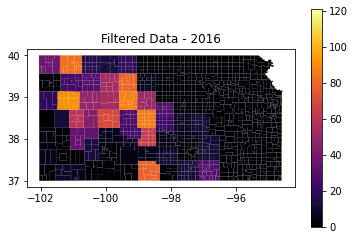

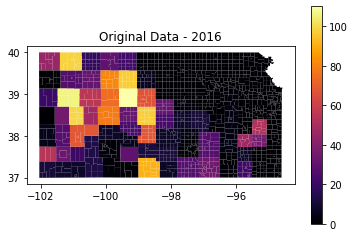

In [19]:
density_map = kansas_map
density_map = density_map.merge(freq_df, on = "COUNTYFP", how = "left")
density_map = density_map.fillna(0)
density_map.plot(column="Frequency", cmap='inferno', legend=True, vmax=raw_location_count.most_common()[0][1])
plt.title(f"Filtered Data - {year}")
plt.savefig(f"maps/filtered_{year}.png")

orignal_map = kansas_map
orignal_map = orignal_map.merge(raw_freq_df, on = "COUNTYFP", how = "left")
original_map = orignal_map.fillna(0)
original_map.plot(column="Frequency", cmap='inferno', legend=True)
plt.title(f"Original Data - {year}")

# Now lets export this Data to a CSV

In [20]:
dataframes = []
for i, w in enumerate(filtered_project):
    df = w.df(uwi=True, keys=keys, alias=alias)
    df[f"well_id"] = [f"{i}{year}" for _ in df.index]# Make Id's based of year just in case I want to merge later
    df.reset_index()
    df.set_index(["well_id"])
    dataframes.append(df)

In [21]:
final_frame = pd.concat(dataframes)

In [22]:
final_frame.to_csv(f"export_csv/formated_{year}.csv")